<a href="https://colab.research.google.com/github/mattiasthalen/Bayesian-Velocity-Profiling/blob/main/Bayesian_Velocity_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Velocity Profiling

## Setup Environment


### Install Libraries

In [ ]:
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade --ignore-requires-python pymc
!pip install --upgrade numpyro
!pip install --upgrade blackjax
!pip install --upgrade pint_xarray
!pip install --upgrade bottleneck
!pip install --upgrade numbagg
!pip install --upgrade ipython-autotime
!pip install --upgrade netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.2 MB/s 
     |████████████████████████████████| 1.4 MB 45.4 MB/s 
     |████████████████████████████████| 52 kB 873 kB/s 
  Attempting uninstall: aesara
    Found existing installation: aesara 2.7.9
    Uninstalling aesara-2.7.9:
      Successfully uninstalled aesara-2.7.9
  Attempting uninstall: aeppl
    Found existing installation: aeppl 0.0.33
    Uninstalling aeppl-0.0.33:
      Successfully uninstalled aeppl-0.0.33
  Attempting uninstall: pymc
    Found existing installation: pymc 4.1.4
    Uninstalling pymc-4.1.4:
      Successfully uninstalled pymc-4.1.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

### Setup Platform

In [ ]:
import numpyro
import jax
import jax.tools.colab_tpu

try:
    
    jax.tools.colab_tpu.setup_tpu()
    numpyro.util.set_platform('tpu')

    print('TPU assigned.')
    display(jax.local_devices())

except:
    print('No TPU available, trying GPU.')
    
    try:
        numpyro.set_platform('gpu')
        print('GPU assigned.')
        display(jax.local_devices())

    except:
        numpyro.set_platform('cpu')
        print('No GPU available, using CPU.')
        display(jax.local_devices())

No TPU available, trying GPU.
GPU assigned.
No GPU available, using CPU.


[CpuDevice(id=0)]

### Load Libraries

In [ ]:
%load_ext autotime

time: 653 µs (started: 2022-10-03 20:23:39 +00:00)


In [ ]:
import pymc as pm
import pymc.sampling_jax

time: 5.64 s (started: 2022-10-03 20:23:39 +00:00)


/usr/local/lib/python3.7/dist-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [ ]:
import time
import pint_xarray
import warnings

import requests
import numpyro
import sklearn.preprocessing
import sklearn.metrics

import pandas as pd
import numpy as np
import arviz as az
import xarray as xr

from jax import numpy as jnp
from numpyro import distributions as dist

from collections import OrderedDict
from google.colab import drive
from requests import get
from urllib.parse import unquote

from requests import get
from urllib.parse import unquote
from matplotlib import pyplot as plt

from typing import Callable, Optional, Dict, List, Union, NoReturn

time: 1.13 s (started: 2022-10-03 20:23:45 +00:00)


### Set Global Vars

In [ ]:
#rng_key = jax.random.PRNGKey(33)
n_devices = np.max([2, len(jax.local_devices())])
numpyro.set_host_device_count(n_devices)

time: 2.02 ms (started: 2022-10-03 20:23:46 +00:00)


In [ ]:
plt.style.use('bmh')

time: 1.76 ms (started: 2022-10-03 20:23:46 +00:00)


In [ ]:
csv_path = 'https://raw.githubusercontent.com/mattiasthalen/Bayesian-Velocity-Profiling/main/RepOne_Data_Export.csv'

time: 777 µs (started: 2022-10-03 20:23:46 +00:00)


## Functions

### ETL Functions

In [ ]:
def extract(csv_path, **kwargs):
    df = pd.read_csv(csv_path)

    df.columns = (df.columns
                    .str.lower()
                    .str.replace(' \(m/s\)', '')
                    .str.replace(' \(mm\)', '')
                    .str.replace(' \(sec\)', '')
                    .str.replace(' \(%\)', '')
                    .str.replace(' ', '_'))
        
    df.rename(columns = {'weight': 'load'}, inplace = True)

    df['workout_start_time'] = pd.to_datetime(df['workout_start_time'], format = '%d/%m/%Y, %H:%M:%S')

    df.dropna(subset = ['exercise'], inplace = True)
    df['rest_time'] = pd.to_timedelta(df['rest_time'])

    # Correct split session
    df['set'].mask((df['exercise'] == 'deadlift') & (df['workout_start_time'] == pd.to_datetime('2020-12-30 13:06:04')), df['set'] + 7, inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2020-12-30 13:06:04')}, pd.to_datetime('2020-12-30 12:53:09'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-01-07 11:50:22')}, pd.to_datetime('2021-01-07 11:20:07'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-10 12:02:22')}, pd.to_datetime('2021-06-10 11:56:31'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-14 12:06:00')}, pd.to_datetime('2021-06-14 11:57:50'), inplace = True)

    # Reindex sets & reps to counter bugs in the extract
    df['set'] = df.groupby(['exercise', 'workout_start_time'])['set'].apply(lambda x: (x != x.shift()).cumsum() - 1)
    df['rep'] = df.groupby(['exercise', 'workout_start_time', 'set']).cumcount()

    # Convert from , to . as decimal sign
    df['load'] = df['load'].str.replace(',', '.').astype('float')

    # Drop rows with tag fail
    fail_filter = df['tags'].str.contains('fail', na = False)
    df = df[~fail_filter]

    # Handle the case when a rep is split into two reps
    rep_split_filter = df['tags'].str.contains('rep split', na = False)

    rep_split_df = df[rep_split_filter].groupby(['exercise', 'workout_start_time', 'set', 'load', 'metric'])[['range_of_motion', 'duration_of_rep']].sum()
    rep_split_df['avg_velocity'] = rep_split_df['range_of_motion']/1000/rep_split_df['duration_of_rep']
    rep_split_df['rep'] = 0
    rep_split_df.reset_index(inplace = True)

    rep_split_df = rep_split_df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    df = pd.concat([df[~rep_split_filter], rep_split_df])

    # Group to get multi index
    df = df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    return df

In [ ]:
def transform(df, **kwargs):
    # Convert to xarray
    ds = df.to_xarray()

    # Change Set and Rep to integers
    ds['set'] = ds['set'].astype(int)
    ds['rep'] = ds['rep'].astype(int)

    # Move variables to coords
    ds = ds.set_coords(['metric', 'tags'])

    # Define UOMs
    ds = ds.pint.quantify({'load': 'kg',
                            'avg_velocity': 'meter / second',
                            'peak_velocity': 'meter / seconds',
                            'range_of_motion': 'mm',
                            'duration_of_rep': 's'})

    # Session meta data
    session_stack = ['exercise', 'workout_start_time']
    ds['session_max_load'] = ds['load'].stack(stack = session_stack)\
                                        .groupby('stack')\
                                        .reduce(all_nan_max, ...)\
                                        .unstack()

    # Set meta data
    set_stack = [*session_stack, 'set']
    ds['load'] = (ds['load'].stack(stack = set_stack)
                            .groupby('stack')
                            .reduce(all_nan_max, ...)
                            .unstack())

    ds['reps'] = (ds['avg_velocity'].stack(stack = set_stack)
                                    .groupby('stack')
                                    .count(...)
                                    .unstack()
                                    .where(ds['load'] > 0, drop = True))

    ds['set_velocities'] = summarize(ds['avg_velocity'].pint.dequantify())
    ds['set_velocities'] = ds['set_velocities'].pint.quantify({ds['set_velocities'].name: 'mps'})

    ds.coords['set_type'] = assign_set_type(ds['load'])

    # Add the running min top set velocity per exercise
    ds['minimum_velocity_threshold'] = (ds['set_velocities'].sel({'aggregation': 'first'})
                                                            .where(ds.coords['set_type'] == 'Top Set')
                                                            .pint.dequantify()
                                                            .stack(stack = session_stack)
                                                            .groupby('stack')
                                                            .reduce(all_nan_min, ...)
                                                            .unstack()
                                                            .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                                    min_periods = 1)
                                                            .min())
    ds['minimum_velocity_threshold'] = ds['minimum_velocity_threshold'].pint.quantify({ds['minimum_velocity_threshold'].name: 'meter / second'})

    # Add running max load per exercise
    ds['rolling_max_load'] = (ds['load'].pint.dequantify()
                                        .stack(stack = session_stack)
                                        .groupby('stack')
                                        .reduce(all_nan_max, ...)
                                        .unstack()
                                        .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                min_periods = 1)
                                        .max())
    ds['rolling_max_load'] = ds['rolling_max_load'].pint.quantify({ds['rolling_max_load'].name: 'kg'})

    # Additional session meta data
    ds['workup_sets'] = ds['load'].where(ds.coords['set_type'] == 'Work Up', drop = True)\
                                    .stack(stack = session_stack)\
                                    .groupby('stack')\
                                    .count(...)\
                                    .unstack()

    #ds['session_regression_coefficients'] = linear_fit(ds, 'load', 'set_velocities', 'set')

    #ds['estimated_1rm'] = linear_predict(ds['minimum_velocity_threshold'].pint.dequantify(), ds['session_regression_coefficients'])
    #ds['estimated_1rm'] = ds['estimated_1rm'].pint.quantify({ds['estimated_1rm'].name: 'kg'})

    #ds['zero_velocity_load'] = linear_predict(0, ds['session_regression_coefficients'])
    #ds['zero_velocity_load'] = ds['zero_velocity_load'].pint.quantify({ds['zero_velocity_load'].name: 'kg'})

    #ds['zero_load_velocity'] = linear_predict(0, ds['session_regression_coefficients'], reverse = True)
    #ds['zero_load_velocity'] = ds['zero_load_velocity'].pint.quantify({ds['zero_load_velocity'].name: 'mps'})

    #ds['curve_score'] = ds['zero_velocity_load'].pint.dequantify()*ds['zero_load_velocity'].pint.dequantify()/2

    ds['session_volume'] = (ds['load'] * ds['reps']).stack(stack = session_stack).groupby('stack').sum(...).unstack()
    #ds['session_relative_volume'] = ds['session_volume']/ds['estimated_1rm']

    # Rep meta data
    #ds['rep_exertion'] = linear_predict(ds['avg_velocity'].pint.dequantify(), ds['session_regression_coefficients'])/ds['estimated_1rm'].pint.dequantify()
    #ds['rep_force'] = (ds['load']*ds['range_of_motion'].pint.to('meter')/ds['duration_of_rep']**2).pint.to('N')
    #ds['rep_energy'] = (ds['rep_force']*ds['range_of_motion'].pint.to('meter')).pint.to('J')

    # Session meta data
    #ds['session_exertion_load'] = ds['rep_exertion'].stack(stack = ['exercise', 'workout_start_time']).groupby('stack').reduce(all_nan_sum, ...).unstack().pint.dequantify()

    # Add PR coordinates
    ds.coords['max_load_pr_flag'] = ds['rolling_max_load'].diff('workout_start_time') > 0
    ds.coords['max_load_pr_flag'] = ds.coords['max_load_pr_flag'].fillna(0).astype(int)

    # Add indexing for inference
    session_shape = [ds.dims[i] for i in session_stack]
    ds.coords['session'] = (session_stack, np.arange(np.prod(session_shape)).reshape(session_shape))

    observation_shape = [ds.dims[i] for i in set_stack]
    ds.coords['observation'] = (set_stack, np.arange(np.prod(observation_shape)).reshape(observation_shape))

    return ds

In [ ]:
def load(csv_path, **kwargs):
    df = extract(csv_path, **kwargs)
    ds = transtorm(df, **kwargs)

    return ds

### Model Functions

In [ ]:
def build_model(velocity,
                load,
                session_idx,
                session_exercise_idx,
                coords,
                render_model = True):
    
    with pm.Model() as model:
        
        # Add coordinates
        model.add_coord(name = 'observation',
                        values = coords['observation'],
                        mutable = True)
        
        model.add_coord(name = 'exercise',
                        values = coords['exercise'],
                        mutable = False)
        
        model.add_coord(name = 'session',
                        values = coords['session'],
                        mutable = False)

        # Add inputs
        velocity = pm.MutableData(name = 'velocity',
                                value = velocity,
                                dims = 'observation')

        # Global Parameters
        intercept_global = pm.Normal(name = 'intercept_global',
                                        mu = 0.0,
                                        sigma = 1.0)
        
        intercept_sigma_global = pm.HalfNormal(name = 'intercept_sigma_global',
                                                sigma = 1.0)
        
        slope_global = pm.HalfNormal(name = 'slope_global',
                                        sigma = 1.0)
        
        curve_global = pm.HalfNormal(name = 'curve_global',
                                        sigma = 1.0)
        
        error_global = pm.HalfNormal(name = 'error_global',
                                        sigma = 1.0)
        
        # Exercise Parameters
        intercept_offset_exercise = pm.Normal(name = 'intercept_offset_exercise',
                                                mu = 0.0,
                                                sigma = 1.0,
                                                dims = 'exercise')
        
        intercept_exercise = pm.Deterministic(name = 'intercept_exercise',
                                                var = intercept_global + intercept_sigma_global*intercept_offset_exercise,
                                                dims = 'exercise')
        
        intercept_sigma_exercise = pm.HalfNormal(name = 'intercept_sigma_exercise',
                                                    sigma = 1.0,
                                                    dims = 'exercise')
        
        slope_exercise = pm.HalfNormal(name = 'slope_exercise',
                                        sigma = slope_global,
                                        dims = 'exercise')
        
        curve_exercise = pm.HalfNormal(name = 'curve_exercise',
                                        sigma = curve_global,
                                        dims = 'exercise')

        # Session Parameters
        intercept_offset_session = pm.Normal(name = 'intercept_offset_session',
                                                mu = 0.0,
                                                sigma = 1.0,
                                                dims = 'session')

        intercept_session = pm.Deterministic(name = 'intercept_session',
                                                var = (intercept_exercise[session_exercise_idx]
                                                        + intercept_sigma_exercise[session_exercise_idx]
                                                        * intercept_offset_session),
                                                dims = 'session')
        
        slope_session = pm.HalfNormal(name = 'slope_session',
                                        sigma = slope_exercise[session_exercise_idx],
                                        dims = 'session')

        curve_session = pm.HalfNormal(name = 'curve_session',
                                        sigma = curve_exercise[session_exercise_idx],
                                        dims = 'session')
        
        # Final Parameters
        intercept = intercept_session[session_idx]
        slope = slope_session[session_idx]
        curve = curve_session[session_idx]
        error = error_global

        # Estimated Value
        load_mu = pm.Deterministic(name = 'mu',
                                    var = intercept - slope*velocity - curve*velocity**2,
                                    dims = 'observation')

        # Likelihood
        load_likelihood = pm.Normal(name = 'load',
                                    mu = load_mu,
                                    sigma = error,
                                    observed = load,
                                    dims = 'observation')
        
    if render_model:
        display(pm.model_to_graphviz(model))
        
    return model

time: 2.64 s (started: 2022-10-03 20:24:08 +00:00)


In [ ]:
def sample(model,
           draws = 1000,
           tune = 1000,
           chains = 1,
           target_accept = 0.8,
           prior_predictive = True,
           posterior_predictive = True):

    with model:
        inference_data = (pm.sampling_jax
                            .sample_numpyro_nuts(draws = draws,
                                                tune = tune,
                                                chains = chains,
                                                target_accept = target_accept))
        
        if prior_predictive:
            inference_data.extend(pm.sample_prior_predictive())

        if posterior_predictive:
            inference_data.extend(pm.sample_posterior_predictive(inference_data))

    return inference_data

Compiling...


/usr/local/lib/python3.7/dist-packages/pymc/sampling_jax.py:555: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  progress_bar=progress_bar,


Compilation time =  0:00:24.922834
Sampling...


sample: 100%|██████████| 2000/2000 [04:12<00:00,  7.92it/s, 1023 steps of size 2.07e-03. acc. prob=0.98]


Sampling time =  0:08:45.164169
Transforming variables...
Transformation time =  0:00:00.726142
Computing Log Likelihood...
Log Likelihood time =  0:00:02.204432


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

time: 9min 30s (started: 2022-10-03 20:24:12 +00:00)


### Plotting Functions

In [ ]:
def plot_pbc(ds, exercise, data_var, window = 20, signal_window = 8, ax = None):
    df = ds[data_var].sel({'exercise': exercise}, drop = True)\
                     .drop_vars(['training_cycle', 'cycle_type', 'max_weight_pr_flag'])\
                     .to_dataframe()\
                     .dropna()
    
    df['moving_average'] = df[data_var].sort_index(ascending = False)\
                                       .rolling(window, min_periods = 1)\
                                       .mean()
    
    df['moving_range'] = df[data_var].diff(-1)\
                                     .abs()\
                                     .sort_index(ascending = False)\
                                     .rolling(window, min_periods = 1)\
                                     .mean()

    df['process_average'] = df['moving_average']
    df['process_range'] = df['moving_range']
    df['signal'] = None
    df['signal_min'] = None
    df['signal_max'] = None
    df['signal_above_average'] = None
    df['signal_below_average'] = None

    n_rows = len(df)
    previous_signal_id = 0

    for row in np.arange(n_rows):
        first_row = row == 0
        sufficient_rows_left = n_rows - row >= window

        signal_start_id = np.max([8, row - signal_window])

        df['signal_min'][row] = df[data_var][signal_start_id:row].min()
        df['signal_max'][row] = df[data_var][signal_start_id:row].max()

        df['signal_above_average'][row] = (df['signal_min'][row] > df['process_average'][row - 1])
        df['signal_below_average'][row] = (df['signal_max'][row] < df['process_average'][row - 1])

        signal_open = (first_row) | (row >= previous_signal_id + window)
        signal = (signal_open) & (sufficient_rows_left) & (first_row | df['signal_above_average'][row] | df['signal_below_average'][row])
        df['signal'][row] = signal
        
        df['process_average'][row] =  df['process_average'][row - 1]
        df['process_range'][row] =  df['process_range'][row - 1]

        if signal:
            previous_signal_id = row
            df['process_average'][row] =  df['moving_average'][row]
            df['process_range'][row] =  df['moving_range'][row]
        else:
            df['process_average'][row] =  df['process_average'][row - 1]
            df['process_range'][row] =  df['process_range'][row - 1]

    df['lower_limit_1'] = df['process_average'] - df['process_range']/1.128
    df['upper_limit_1'] = df['process_average'] + df['process_range']/1.128
    df['lower_limit_2'] = df['process_average'] - df['process_range']*2/1.128
    df['upper_limit_2'] = df['process_average'] + df['process_range']*2/1.128
    df['lower_limit_3'] = df['process_average'] - df['process_range']*3/1.128
    df['upper_limit_3'] = df['process_average'] + df['process_range']*3/1.128

    if ax is None:
        ax = plt.gca()

    ax.scatter(df.index, df[data_var], marker = '.', alpha = 0.6)
    ax.plot(df.index, df['process_average'])
    ax.plot(df.index, df['lower_limit_3'])
    ax.plot(df.index, df['upper_limit_3'])

    ax.fill_between(df.index,df['lower_limit_1'], df['upper_limit_1'], alpha = 0.3)

    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_ylim([0, None])
    ax.tick_params(labelrotation = 90)
    ax.grid()

    return ax

time: 13.3 ms (started: 2022-10-03 20:23:46 +00:00)


In [ ]:
def plot_kpis(ds, exercise, vars):
    var_titles = [var.title().replace('_', ' ').replace('1Rm', '1RM') for var in vars]

    n_vars = len(vars)

    n_cols = 1

    if n_vars > 1:
        n_cols = 2
    
    n_rows = 1

    if n_vars > 2:
        n_rows = np.ceil(n_vars/n_cols).astype(int)
    
    figsize = np.array([6, 3]) * [n_cols, n_rows]

    fig, axes = plt.subplots(ncols = n_cols,
                            nrows = n_rows,
                            constrained_layout = True,
                            figsize = figsize,
                            sharex = True)
    
    axes = [ax for row in axes for ax in row]

    for key, val in enumerate(vars):
        plot_pbc(ds, exercise, vars[key], ax = axes[key])
        title = var_titles[key]
        axes[key].set_title(title)

    fig.suptitle(f'{exercise.title()} KPIs', fontsize = 16)
    fig.supxlabel('Workout Start Time')

    plt.draw()

time: 4.31 ms (started: 2022-10-03 20:23:46 +00:00)


### Miscellaneous Functions

In [ ]:
def assign_set_type(da):
    set_category = xr.where(da['set'] < da.idxmax('set'), 'Work Up', np.nan)
    set_category = xr.where(da['set'] == da.idxmax('set'), 'Top Set', set_category)
    set_category = xr.where(da['set'] > da.idxmax('set'), 'Back Off', set_category)
    set_category = xr.where(np.isnan(da), np.nan, set_category)
    
    return set_category

time: 2.32 ms (started: 2022-10-03 20:23:46 +00:00)


In [ ]:
def agg_summarize(x):
    x = x[np.isfinite(x)]

    if len(x) > 0:
        min = np.min(x)
        max = np.max(x)
        first = x[0]
        last = x[-1]
        peak_end = np.mean([min, last])
        mean = np.mean(x)
        median = np.median(x)
        hdi = az.hdi(x)
        result = np.array([min, max, first, last, peak_end, mean, median, *hdi])
    else:
        result = np.array([np.nan]*9)
    
    return result

def summarize(x, reduce_dim = 'rep'):
    summaries = xr.apply_ufunc(agg_summarize,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['aggregation']])
    
    summaries['aggregation'] = ['min', 'max', 'first', 'last', 'peak_end', 'mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 24.6 ms (started: 2022-10-03 20:23:46 +00:00)


In [ ]:
def agg_hdi_summary(x):
    mean = x.mean()
    median = np.median(x)
    hdi = az.hdi(x)

    return np.array([mean, median, *hdi])

def hdi_summary(x, reduce_dim = 'sample'):
    try:
        x = x.pint.dequantify()
    except:
        pass

    summaries = xr.apply_ufunc(agg_hdi_summary,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['hdi_aggregation']])
    
    summaries['hdi_aggregation'] = ['mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 2.06 ms (started: 2022-10-03 20:23:46 +00:00)


In [ ]:
def all_nan_summary(x, mode = 'mean', **kwargs):
    if np.all(np.isnan(x)):
        return np.nan
    elif mode == 'max':
        return np.nanmax(x)
    elif mode == 'min':
        return np.nanmin(x)
    elif mode == 'mean':
        return np.nanmean(x)
    elif mode == 'sum':
        return np.nansum(x)
        
def all_nan_max(x, **kwargs):
    return all_nan_summary(x, 'max', **kwargs)
        
def all_nan_min(x, **kwargs):
    return all_nan_summary(x, 'min', **kwargs)
        
def all_nan_mean(x, **kwargs):
    return all_nan_summary(x, 'mean', **kwargs)
        
def all_nan_sum(x, **kwargs):
    return all_nan_summary(x, 'sum', **kwargs)

time: 3.47 ms (started: 2022-10-03 20:23:46 +00:00)


## Inference

In [ ]:
ds = load(csv_path)

ds

In [ ]:
regr_data = (ds[['load', 'set_velocities', 'observation', 'session']]
             .pint.dequantify()
             .sel({'aggregation': 'max'}, drop = True)
             .where(ds.coords['set_type'] != 'Back Off')
             .where(ds.coords['exercise'] != 'front squat')
             .drop_vars(['set_type', 'max_load_pr_flag'])
             .to_dataframe()
             .dropna()
             .reset_index()
             .drop(['set', 'workout_start_time'], axis = 1)
             .rename(columns = {'set_velocities': 'velocity'}))

# Standardize data to simplify inference
load_scaler = sklearn.preprocessing.StandardScaler()
regr_data['load_scaled'] = load_scaler.fit_transform(regr_data['load'].values.reshape(-1, 1))

velocity_scaler = sklearn.preprocessing.StandardScaler()
regr_data['velocity_scaled'] = velocity_scaler.fit_transform(regr_data['velocity'].values.reshape(-1, 1))

regr_data

,exercise,load,velocity,observation,session,load_scaled,velocity_scaled
0,bench press,20.0,0.77,44,2,-1.292008,0.489433
1,bench press,30.0,0.77,45,2,-1.045460,0.489433
2,bench press,40.0,0.59,46,2,-0.798912,-0.078098
3,bench press,50.0,0.46,47,2,-0.552364,-0.487981
4,bench press,60.0,0.44,48,2,-0.305817,-0.551040
...,...,...,...,...,...,...,...
2884,squat,80.0,0.67,20551,934,0.187279,0.174138
2885,squat,100.0,0.53,20552,934,0.680375,-0.267275
2886,squat,120.0,0.38,20553,934,1.173470,-0.740217
2887,squat,130.0,0.33,20554,934,1.420018,-0.897865


time: 56.8 ms (started: 2022-10-03 20:24:08 +00:00)


In [ ]:
velocity_scaled = regr_data['velocity_scaled'].astype(np.float32)
load_scaled = regr_data['load_scaled'].astype(np.float32)

observation = regr_data['observation'].astype(np.int32)

exercises = regr_data['exercise']
exercise_encoder = sklearn.preprocessing.LabelEncoder()
exercise_encoder.fit(exercises)

sessions = regr_data['session'].astype(np.int32)
session_encoder = sklearn.preprocessing.LabelEncoder()
session_idx = session_encoder.fit_transform(sessions).astype(np.int32)

session_exercise = (regr_data.reset_index()[['session', 'exercise']]
                    .drop_duplicates()
                    .set_index('session', verify_integrity = True)
                    .sort_index()['exercise']
                    .values)

session_exercise_idx = exercise_encoder.transform(session_exercise).astype(np.int32)

coords = {'observation': observation,
          'exercise': exercise_encoder.classes_,
          'session': session_encoder.classes_}

model_data = {'velocity': velocity_scaled,
              'load': load_scaled,
              'session_idx': session_idx,
              'session_exercise_idx': session_exercise_idx,
              'coords': coords}

model = build_model(**model_data)

time: 13.7 ms (started: 2022-10-03 20:24:08 +00:00)


In [ ]:
inference_data = sample(model, chains = 2, target_accept = 0.98)

## Plot

In [ ]:
inference_summary = az.summary(inference_data,
                               var_names = ['~mu', '~session', '~sigma', '~offset', 'intercept', 'slope', 'curve', 'error'],
                               filter_vars = 'like',
                               hdi_prob = 0.9)
inference_summary

NameError: ignored

### Trace

In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_global', 'slope_global', 'curve_global', 'error_global'])

In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  legend = True,
                  figsize = [15, 20],
                  var_names = ['intercept_exercise', 'slope_exercise', 'curve_exercise'])

In [ ]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_session', 'slope_session', 'curve_session'])

### Last Session Plot

/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

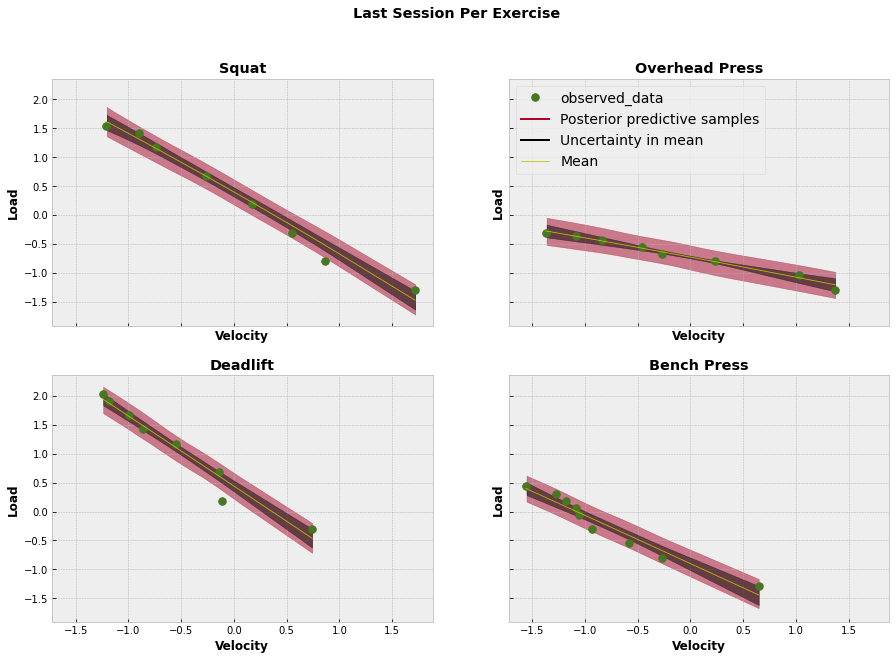

time: 1.29 s (started: 2022-10-03 20:33:43 +00:00)


In [ ]:
exercises = ['squat', 'overhead press', 'deadlift', 'bench press']
n_exercises = len(exercises)

n_rows = np.ceil(n_exercises / 2).astype(int)
n_cols = n_exercises - n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 10), sharex = True, sharey = True)

axes = axes.flatten()

for i, ax in enumerate(axes):

    exercise = exercises[i]

    last_session = regr_data[regr_data['exercise'] == exercise]['session'].max()
    last_session_observations = regr_data[regr_data['session'] == last_session]['observation'].values

    last_session_idata = inference_data.sel(observation = last_session_observations, session = last_session, exercise = exercise)

    az.plot_lm(idata = last_session_idata,
               x = 'velocity',
               y = 'load',
               y_hat = 'load',
               y_model = 'mu',
               kind_pp = 'hdi',
               kind_model = 'hdi',
               y_kwargs = {'marker': '.', 'zorder': 10},
               legend = True if i == 1 else False,
               axes = ax)
    
    ax.set_title(exercise.title(), fontweight = 'bold')
    ax.set_xlabel('Velocity', fontweight = 'bold')
    ax.set_ylabel('Load', fontweight = 'bold')

fig.suptitle('Last Session Per Exercise',
             fontweight = 'bold',
             fontsize = 'x-large')

plt.show()